# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.


In the repository, it is already provided the linux version:


In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains two agents playing tennis.  At each time step, it has two continuous actions at its disposal:
- move left-right 
- jump

The state space has `24` dimensions and contains the ball's position and velocity, along with the postion and velocity of the rackets.  A reward of `+0.1` is provided for pushing the ball over the net, and a reward of `-0.01` is provided for dropping the ball or pushing outside. 

Run the code cell below to print some information about the environment.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


env_info = env.reset(train_mode=True)[brain_name]

NUM_AGENTS = len(env_info.agents)
STATE_SIZE = env_info.vector_observations.shape[1]
ACTION_SIZE = brain.vector_action_space_size

print('Agents count:', NUM_AGENTS)
print('State size:', STATE_SIZE)
print('Action size:', ACTION_SIZE)

Agents count: 2
State size: 24
Action size: 2


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it play tennis.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
for _ in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(NUM_AGENTS)                       # initialize the score
    dones = np.zeros(NUM_AGENTS)                        # initialize the done
    actions = np.zeros((NUM_AGENTS, ACTION_SIZE))
    while not np.any(dones):
        actions = np.random.randn(NUM_AGENTS, ACTION_SIZE)
        # random actions but clipped to -1,1
        actions = np.clip(actions, -1, 1)
        # send the action to the environment
        env_info = env.step(actions)[brain_name]
        rewards = env_info.rewards                      # get the reward
        dones = env_info.local_done                     # see if episode has finished
        scores += rewards                               # update the score
        next_states = env_info.vector_observations
        states = next_states

    max_score = np.max(scores)
    print("Score: {}".format(max_score))

Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Familiarize with `agent.py`, `network.py`, `replay_buffer.py`.

The `Agent` is the core of the algorithm, it predicts the next step. It store a local and a target network that are used to predict and train the the agent. It is an actor critic agent.

The `ActorNetwork` and `CriticNetwork` are the deep networks we use for predicting the next move and the Q values for a given state.


The `ReplayBuffer` is where we store the previous states/rewards/... we will sample this during the training.

Most of the hyper parameter can be found in the `agent.py`.

In the following block we are training the two agents. Note how we add some noise to the chosen actions in order to explore more the environment. We will gradually reduce the noise during the optimization.

In [6]:
from agent import Agent
from collections import deque
import torch
from torch.distributions import normal

agent_zero = Agent(STATE_SIZE, ACTION_SIZE)
agent_one = Agent(STATE_SIZE, ACTION_SIZE)
print(agent_zero)
print(agent_one)

std_initial = 0.15
std_final = 0.05
std_decrease = 1.0-1.0e-4
std = std_initial

target = 0.5
scores=[]
scores_window = deque(maxlen=100)
for i_episode in range(10000):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations
    score = np.zeros(NUM_AGENTS)

    noise_distribution = normal.Normal(0, std)
    while True:
        action_zero = agent_zero.act(
            state[0]) + noise_distribution.sample((ACTION_SIZE,))
        action_one = agent_one.act(
            state[1]) + noise_distribution.sample((ACTION_SIZE,))

        actions = np.vstack((action_zero.numpy(), action_one.numpy()))
        actions = np.clip(actions, -1, 1)

        env_info = env.step(actions)[brain_name]
        next_state = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        agent_zero.step(state[0], actions[0], rewards[0],
                        next_state[0], dones[0])
        agent_one.step(state[1], actions[1], rewards[1],
                       next_state[1], dones[1])
        score += env_info.rewards
        state = next_state
        if np.any(dones):
            break

    std = max(std*std_decrease, std_final)
    score = np.max(score)
    
    scores.append(score)
    scores_window.append(score)
    average_score = np.mean(scores_window)
    max_score = np.max(scores_window)
    
    print('\rEpisode {}\tScore: {:.4f}\tMean Score: {:.4f}\tMax Score: {:.4f}\tStd: {:.4f}'.format(
        i_episode, score, average_score, max_score, std), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tScore: {:.4f}\tMean Score: {:.4f}\tMax Score: {:.4f}\tStd: {:.4f}'.format(
            i_episode, score, average_score, max_score, std))
    if average_score >= target:
        print("\nSolved in {} episodes.".format(i_episode))
        agent_zero.save("agent_zero.pth")
        agent_one.save("agent_one.pth")
        break

Agent
Actor: ActorNetwork(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)
Critic: CriticNetwork(
  (fc1): Linear(in_features=26, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
Agent
Actor: ActorNetwork(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)
Critic: CriticNetwork(
  (fc1): Linear(in_features=26, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
Episode 0	Score: 0.0000	Mean Score: 0.0000	Max Score: 0.0000	Std: 0.1500
Episode 3	Score: 0.0000	Mean Score: 0.0000	Max Score: 0.0000	Std: 0.1499

/home/stefano/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Score: 0.0000	Mean Score: 0.0010	Max Score: 0.1000	Std: 0.1485
Episode 200	Score: 0.0000	Mean Score: 0.0000	Max Score: 0.0000	Std: 0.1470
Episode 300	Score: 0.0000	Mean Score: 0.0000	Max Score: 0.0000	Std: 0.1456
Episode 400	Score: 0.0000	Mean Score: 0.0000	Max Score: 0.0000	Std: 0.1441
Episode 500	Score: 0.0000	Mean Score: 0.0000	Max Score: 0.0000	Std: 0.1427
Episode 600	Score: 0.0000	Mean Score: 0.0000	Max Score: 0.0000	Std: 0.1413
Episode 700	Score: 0.0000	Mean Score: 0.0037	Max Score: 0.1000	Std: 0.1398
Episode 800	Score: 0.0000	Mean Score: 0.0054	Max Score: 0.0900	Std: 0.1385
Episode 900	Score: 0.0000	Mean Score: 0.0110	Max Score: 0.1000	Std: 0.1371
Episode 1000	Score: 0.0000	Mean Score: 0.0010	Max Score: 0.1000	Std: 0.1357
Episode 1100	Score: 0.0000	Mean Score: 0.0050	Max Score: 0.1000	Std: 0.1344
Episode 1200	Score: 0.0000	Mean Score: 0.0149	Max Score: 0.1000	Std: 0.1330
Episode 1300	Score: 0.0000	Mean Score: 0.0000	Max Score: 0.0000	Std: 0.1317
Episode 1400	Score: 0

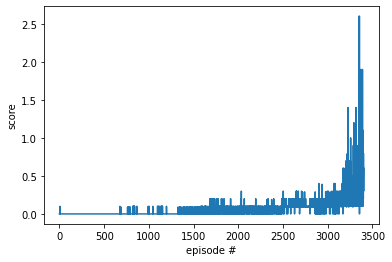

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('score')
plt.xlabel('episode #')
plt.savefig('training_history.png')
plt.show()


Now we can test our trained agent without noise.

In [8]:
from agent import Agent
from collections import deque
import torch

trained_agent_zero = Agent(STATE_SIZE, ACTION_SIZE)
trained_agent_one = Agent(STATE_SIZE, ACTION_SIZE)
trained_agent_zero.load('agent_zero.pth')
trained_agent_one.load('agent_one.pth')

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations 
score = np.zeros(NUM_AGENTS)                       # initialize the score
while True:
    action_zero = trained_agent_zero.act(state[0])
    action_one = trained_agent_one.act(state[1])
    action = np.vstack((action_zero.numpy(), action_one.numpy()))
    env_info = env.step(action)[brain_name]     # send the action to the environment
    next_state = env_info.vector_observations   # get the next state
    reward = env_info.rewards                   # get the reward
    done = env_info.local_done                  # see if episode has finished
    score += reward                             # update the score
    state = next_state                          # roll over the state to next time step
    if np.any(done):                           # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: [2.50000004 2.60000004]


When finished, you can close the environment.

In [9]:
env.close()